# Needed libraries

In [1]:
import numpy as np
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib import patches
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import sys

thismodule = sys.modules[__name__]

In [2]:
from read_lhco import read_lhco

In [39]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
import matplotlib as mpl

# Signal events

In [27]:
signal_NLO  = 1.25
luminosidad = 100

cross_section_bps    = np.asarray([185.2, 185.2, 100.5, 100.5, 48.5, 48.5, 26.8, 26.8])
branching_ratios_bps = np.asarray([0.96 , 0.97 , 0.93 , 0.79 , 0.95, 0.96, 0.94, 0.92])

signal_cross = cross_section_bps * branching_ratios_bps *  0.2134 # fb

fid_cross_sections = np.zeros(len(cross_section_bps))
expected_events = np.zeros(len(cross_section_bps))
sim_events = np.zeros(len(cross_section_bps))
cut_events = np.zeros(len(cross_section_bps))

In [28]:
write = True

#bp_number = 1

for bp_number in [1,2,3,4,8]:

    signal_cut_ev  = 0
    signal_init_ev = 0

    counter_bad_jets = 0
    contador_tau     = 0
    signal_runs = os.listdir(f'../data/BP{bp_number}/')
    for ii, file in enumerate(signal_runs):
        print(ii)
        inputevents = read_lhco(f'../data/BP{bp_number}/' + file, OutputType = 'dict')
        signal_init_ev += len(inputevents)
        print('Esta run tuvo ' + str(len(inputevents)) + ' eventos en el lhco')
        
        for i in range(len(inputevents)):
    
            # at least one: photon, jet and lepton (electron or muon)
            if len(inputevents[i]["photon"]) > 0 and len(inputevents[i]["jet"]) > 0 and (len(inputevents[i]["electron"]) > 0 or len(inputevents[i]["muon"]) > 0):
                if inputevents[i]["jet"][0]["pt"] > 100 and -4.5 < inputevents[i]["jet"][0]["eta"] < 4.5:
                    if inputevents[i]["photon"][0]["pt"] > 10 and -2.37 < inputevents[i]["photon"][0]["eta"] < 2.37:
                        if inputevents[i]["met"][0]["pt"] > 100:
    
                            # lepton info
                            if (len(inputevents[i]["electron"]) > 0) and (len(inputevents[i]["muon"]) > 0):
                                if inputevents[i]["electron"][0]["pt"] > inputevents[i]["muon"][0]["pt"]: 
                                    flag = 'electron'
                                    eta_leading_lepton = inputevents[i]["electron"][0]["eta"]
                                else: 
                                    flag = 'muon'
                                    eta_leading_lepton = -2. # Esto es para q el corte sea solo cuando el leading lepton es un electron
                            elif (len(inputevents[i]["electron"]) > 0) and (len(inputevents[i]["muon"]) == 0): 
                                flag = 'electron'
                                eta_leading_lepton = inputevents[i]["electron"][0]["eta"]
                            elif (len(inputevents[i]["muon"]) > 0) and (len(inputevents[i]["electron"]) == 0): 
                                flag = 'muon'
                                eta_leading_lepton = -2. # Esto es para q el corte sea solo cuando el leading lepton es un electron
    
                            if (-2.47 < eta_leading_lepton < -1.52) or (-1.37 < eta_leading_lepton < 1.37) or (1.52 < eta_leading_lepton < 2.47): 
    
                                # how many jets (total) and total hadronic pT
                                flag_bad_jets = 0                            
                                num_jets = 0
                                HT_had = 0 # hadronic activity HT, defined as the scalar sum of the pT of all reconstructed jets
                                HT = 0 # total HT, defined as the scalar sum of the pT of all reconstructed particles
    
                                for j in range(len(inputevents[i]["jet"])):
                                    if (inputevents[i]["jet"][j]["pt"] > 20) and (-4.5 < inputevents[i]["jet"][j]["eta"] < 4.5):
                                        num_jets += 1
                                        HT_had += inputevents[i]["jet"][j]["pt"]
                                        HT += inputevents[i]["jet"][j]["pt"]
                                    if (np.abs(inputevents[i]["jet"][j]["eta"]) > 4.5) or (inputevents[i]["jet"][j]["pt"] < 20):
                                        flag_bad_jets = 1
    
                                # how many photons                         
                                num_photons = 0
                                for j in range(len(inputevents[i]["photon"])):
                                    if inputevents[i]["photon"][j]["pt"] > 10 and -2.37 < inputevents[i]["photon"][j]["eta"] < 2.37:
                                        num_photons = num_photons + 1
                                        HT += inputevents[i]["photon"][j]["pt"]
    
                                # how many muons                        
                                num_muons = 0
                                for j in range(len(inputevents[i]["muon"])):
                                    if inputevents[i]["muon"][j]["pt"] > 10 and -2.7 < inputevents[i]["muon"][j]["eta"] < 2.7:
                                        num_muons = num_muons + 1
                                        HT += inputevents[i]["muon"][j]["pt"]
    
                                # how many electrons                        
                                num_electrons = 0
                                for j in range(len(inputevents[i]["electron"])):
                                    if inputevents[i]["electron"][j]["pt"] > 10:
                                        eta = inputevents[i]["electron"][j]["eta"]
                                        if (-2.47 < eta < -1.52) or (-1.37 < eta < 1.37) or (1.52 < eta < 2.47): 
                                            num_electrons = num_electrons + 1
                                            HT += inputevents[i]["electron"][j]["pt"]
    
                                if flag_bad_jets == 1: counter_bad_jets += 1 
                                if flag_bad_jets == 0:
                                    num_taus = 0
                                    if len(inputevents[i]["tau"]) > 0: 
                                        contador_tau = contador_tau + 1
                                        # how many taus                    
                                        for j in range(len(inputevents[i]["tau"])):
                                            if inputevents[i]["tau"][j]["pt"] > 20:
                                                eta = inputevents[i]["tau"][j]["eta"]
                                                if (-2.47 < eta < -1.52) or (-1.37 < eta < 1.37) or (1.52 < eta < 2.47): 
                                                    num_taus = num_taus + 1
                                                    HT += inputevents[i]["tau"][j]["pt"]
    
                                    if write:                
                                        # photon info:
                                        with open(f'../data/BP{bp_number}/photon_100.dat', 'a') as f:
                                            f.write('%f %f %f %d\n' % (inputevents[i]["photon"][0]["pt"],inputevents[i]["photon"][0]["eta"],inputevents[i]["photon"][0]["phi"], num_photons))
    
                                        # jet info:
                                        with open(f'../data/BP{bp_number}/jet_100.dat', 'a') as f:
                                            f.write('%f %f %f\n' % (inputevents[i]["jet"][0]["pt"],inputevents[i]["jet"][0]["eta"],inputevents[i]["jet"][0]["phi"]))
    
                                        # lepton info
                                        num_leptons = num_electrons + num_muons
                                        if flag == 'electron':
                                            with open(f'../data/BP{bp_number}/lepton_100.dat', 'a') as f:
                                                f.write('%f %f %f %d %d\n' % (inputevents[i]["electron"][0]["pt"],inputevents[i]["electron"][0]["eta"],inputevents[i]["electron"][0]["phi"], num_leptons, num_taus))
                                        else:
                                            with open(f'../data/BP{bp_number}/lepton_100.dat', 'a') as f:
                                                f.write('%f %f %f %d %d\n' % (inputevents[i]["muon"][0]["pt"],inputevents[i]["muon"][0]["eta"],inputevents[i]["muon"][0]["phi"], num_leptons, num_taus))
    
                                        # MET (eta=0 by def, but I save phi because I have many jets)
                                        with open(f'../data/BP{bp_number}/MET_100.dat', 'a') as f:
                                            f.write('%f %f %f\n' % (inputevents[i]["met"][0]["pt"],inputevents[i]["met"][0]["eta"],inputevents[i]["met"][0]["phi"]))
    
                                        # hadronic info
                                        with open(f'../data/BP{bp_number}/hadinfo_100.dat', 'a') as f:
                                            f.write('%f %f %d\n' % (HT, HT_had, num_jets))
    
                                    # total events that passed the cuts
                                    signal_cut_ev += 1
    
    print('Num initial events: ', signal_init_ev)
    print('Total pasaron los cortes: ', signal_cut_ev)
    print('Hay: ', contador_tau, ' taus')
    print('Hay: ', counter_bad_jets, ' eventos con al menos un jet malo')
    
    
    cross       = signal_cross[bp_number-1] * signal_NLO
    aceptancia  = signal_cut_ev / signal_init_ev
    
    signal_fidcross = cross * aceptancia
    signal_expected = cross * aceptancia * luminosidad
    
    fid_cross_sections[bp_number - 1] = signal_fidcross
    expected_events[bp_number - 1] = signal_expected
    sim_events[bp_number - 1] = signal_init_ev
    cut_events[bp_number - 1] = signal_cut_ev
    print('fiducial cross section: ', signal_fidcross)
    print('Events expected: ', signal_expected)

0
Esta run tuvo 100000 eventos en el lhco
1
Esta run tuvo 100000 eventos en el lhco
2
Esta run tuvo 100000 eventos en el lhco
3
Esta run tuvo 100000 eventos en el lhco
4
Esta run tuvo 100000 eventos en el lhco
5
Esta run tuvo 100000 eventos en el lhco
6
Esta run tuvo 100000 eventos en el lhco
7
Esta run tuvo 100000 eventos en el lhco
8
Esta run tuvo 100000 eventos en el lhco
Num initial events:  900000
Total pasaron los cortes:  121854
Hay:  1483  taus
Hay:  1241  eventos con al menos un jet malo
fiducial cross section:  6.42116639296
Events expected:  642.116639296
0
Esta run tuvo 100000 eventos en el lhco
1
Esta run tuvo 100000 eventos en el lhco
2
Esta run tuvo 100000 eventos en el lhco
3
Esta run tuvo 100000 eventos en el lhco
4
Esta run tuvo 100000 eventos en el lhco
5
Esta run tuvo 100000 eventos en el lhco
6
Esta run tuvo 100000 eventos en el lhco
7
Esta run tuvo 100000 eventos en el lhco
8
Esta run tuvo 100000 eventos en el lhco
9
Esta run tuvo 100000 eventos en el lhco
10
Esta

In [29]:
print('Fid cross sections: ', fid_cross_sections)
print('Expected events: ', expected_events)
print('Simulated events: ', sim_events)
print('Number of events after cuts: ', cut_events)

Fid cross sections:  [6.42116639 5.82331662 2.79433826 2.95808087 0.         0.
 0.         1.07832349]
Expected events:  [642.1166393  582.33166194 279.43382619 295.80808675   0.
   0.           0.         107.83234906]
Simulated events:  [ 900000. 1300000. 1500000. 1000000.       0.       0.       0. 1000000.]
Number of events after cuts:  [121854. 157978. 168119. 139673.      0.      0.      0. 163954.]


# Plots (MET > 100)

## Reading SM data

In [10]:
ttgamma_cross = 0.13 * 1000 #[fb]
ttgamma_NLO   = 1.46 # k-factor [14 TeV]

wgamma_cross = 0.944 * 1000 #[fb]
wgamma_NLO   = 2.37 # k-factor [14 TeV]

wjets_cross = 168.12 * 1000 #[fb]
wjets_NLO   = 1.27 # k-factor [14 TeV]

ttjets_cross = 29.0495 * 1000 # [fb]
ttjets_NLO   = 1.47

zjets_cross = 65.85 * 1000 # [fb] solo rama leptonica
zjets_NLO   = 1.35

wz_cross = 0.90 * 1000 # [fb]
wz_NLO   = 1.62

zz_cross = 0.2616 * 1000
zz_NLO   = 1.29

ww_cross = 0.409 * 1000
ww_NLO   = 1.40

tj_cross = 1.598 * 1000
tj_NLO   = 1.03

tb_cross = 2.882 * 1000
tb_NLO   = 1.34

tw_cross = 1.441 * 1000
tw_NLO   = 1.

In [11]:
wgamma_fidcross  = 584.6234
wjets_fidcross   = 600.5788
ttgamma_fidcross = 24.98413

ttjets_fidcross  = 180.510721
zjets_fidcross   = 33.609922
wz_fidcross      = 6.740334
zz_fidcross      = 0.843997
ww_fidcross      = 15.8203
tj_fidcross      = 7.9070
tb_fidcross      = 11.52578
tw_fidcross      = 12.72042

bkg = ['wgamma', 'wjets', 'ttgamma',
       'zjets',
       'ttjets',
       'tj', 'tb', 'tw',
       'ww', 'zz', 'wz'
      ]

B_fidcross_tot = 0
for i, ibkg in enumerate(bkg):
    B_fidcross_tot = B_fidcross_tot + globals()[ibkg + '_fidcross']
B_fidcross_tot

1479.8648040000003

In [12]:
wgamma_aceptancia_init  = wgamma_fidcross / (wgamma_cross * wgamma_NLO)
wjets_aceptancia_init   = wjets_fidcross / (wjets_cross * wjets_NLO)
ttgamma_aceptancia_init = ttgamma_fidcross / (ttgamma_cross * ttgamma_NLO)
ttjets_aceptancia_init  = ttjets_fidcross / (ttjets_cross * ttjets_NLO)
zjets_aceptancia_init   = zjets_fidcross / (zjets_cross * zjets_NLO)
wz_aceptancia_init      = wz_fidcross / (wz_cross * wz_NLO)
zz_aceptancia_init      = zz_fidcross / (zz_cross * zz_NLO)
ww_aceptancia_init      = ww_fidcross / (ww_cross * ww_NLO)
tj_aceptancia_init      = tj_fidcross / (tj_cross * tj_NLO)
tb_aceptancia_init      = tb_fidcross / (tb_cross * tb_NLO)
tw_aceptancia_init      = tw_fidcross / (tw_cross * tw_NLO)

In [13]:
wgamma_expected  = 58462.34
wjets_expected   = 60057.88
ttgamma_expected = 2498.413

ttjets_expected  = 18051.0721
zjets_expected   = 3360.9922
wz_expected      = 674.0334
zz_expected      = 84.3997
ww_expected      = 1582.03
tj_expected      = 790.70
tb_expected      = 1152.578
tw_expected      = 1272.042

B_expected = 0
for i, ibkg in enumerate(bkg):
    B_expected = B_expected + globals()[ibkg + '_expected']
B_expected

147986.4804

In [14]:
sample = 200_000 # Number of signal and background events to train and validate

wgamma_sample  = int(round(sample * wgamma_fidcross / B_fidcross_tot))
wjets_sample   = int(round(sample * wjets_fidcross / B_fidcross_tot))
ttgamma_sample = int(round(sample * ttgamma_fidcross / B_fidcross_tot))
ttjets_sample = int(round(sample * ttjets_fidcross / B_fidcross_tot))
zjets_sample = int(round(sample * zjets_fidcross / B_fidcross_tot))
wz_sample = int(round(sample * wz_fidcross / B_fidcross_tot))
zz_sample = int(round(sample * zz_fidcross / B_fidcross_tot))
ww_sample = int(round(sample * ww_fidcross / B_fidcross_tot))
tj_sample = int(round(sample * tj_fidcross / B_fidcross_tot))
tb_sample = int(round(sample * tb_fidcross / B_fidcross_tot))
tw_sample = int(round(sample * tw_fidcross / B_fidcross_tot))

print(wgamma_sample)
print(wjets_sample)
print(ttgamma_sample)
print(ttjets_sample)
print(zjets_sample)
print(wz_sample)
print(zz_sample)
print(ww_sample)
print(tj_sample)
print(tb_sample)
print(tw_sample)

79010
81167
3377
24396
4542
911
114
2138
1069
1558
1719


In [15]:
datFolderwgamma  = '../../susyatLHC/data/Wgamma/'
datFolderwjets   = '../../susyatLHC/data/Wjets/'
datFolderttgamma = '../../susyatLHC/data/ttGamma/'
datFolderttjets  = '../../susyatLHC/data/ttjets/'
datFolderzjets   = '../../susyatLHC/data/Zlep+j/'
datFolderwz      = '../../susyatLHC/data/wz/'
datFolderww      = '../../susyatLHC/data/ww/'
datFolderzz      = '../../susyatLHC/data/zz/'
datFoldertj      = '../../susyatLHC/data/singleTop+j/'
datFoldertb      = '../../susyatLHC/data/singleTop+b/'
datFoldertw      = '../../susyatLHC/data/singleTop+W/'

for i, ibkg in enumerate(bkg):
    aux = np.loadtxt(globals()['datFolder' + ibkg] + 'photon_4.dat', delimiter=' ')
    setattr(thismodule, 'photon_' + ibkg, aux)
    aux = np.loadtxt(globals()['datFolder' + ibkg] + 'jet_4.dat', delimiter=' ')
    setattr(thismodule, 'jet_' + ibkg, aux)
    aux = np.loadtxt(globals()['datFolder' + ibkg] + 'lepton_4.dat', delimiter=' ')
    setattr(thismodule, 'lepton_' + ibkg, aux)
    aux = np.loadtxt(globals()['datFolder' + ibkg] + 'MET_4.dat', delimiter=' ')
    setattr(thismodule, 'MET_' + ibkg, aux)
    aux = np.loadtxt(globals()['datFolder' + ibkg] + 'hadinfo_4.dat', delimiter=' ')
    setattr(thismodule, 'hadinfo_' + ibkg, aux)

In [16]:
for i, ibkg in enumerate(bkg):
    if i == 0:
        photon_SM  = globals()['photon_' + ibkg][:globals()[ibkg + '_sample']]
        jet_SM     = globals()['jet_' + ibkg][:globals()[ibkg + '_sample']]
        lepton_SM  = globals()['lepton_' + ibkg][:globals()[ibkg + '_sample']]
        MET_SM     = globals()['MET_' + ibkg][:globals()[ibkg + '_sample']]
        hadinfo_SM = globals()['hadinfo_' + ibkg][:globals()[ibkg + '_sample']]
    else:
        photon_SM  = np.concatenate([photon_SM, globals()['photon_' + ibkg][:globals()[ibkg + '_sample']]])
        jet_SM     = np.concatenate([jet_SM, globals()['jet_' + ibkg][:globals()[ibkg + '_sample']]])
        lepton_SM  = np.concatenate([lepton_SM, globals()['lepton_' + ibkg][:globals()[ibkg + '_sample']]])
        MET_SM     = np.concatenate([MET_SM, globals()['MET_' + ibkg][:globals()[ibkg + '_sample']]])
        hadinfo_SM = np.concatenate([hadinfo_SM, globals()['hadinfo_' + ibkg][:globals()[ibkg + '_sample']]])

In [17]:
bkg_flag = np.zeros(len(photon_SM))

for i, ibkg in enumerate(bkg):
    if i == 0:
        bkg_flag[:globals()[ibkg + '_sample']] = i + 1
        end_ind = globals()[ibkg + '_sample']
    else:
        init_ind = end_ind
        end_ind  = end_ind + globals()[ibkg + '_sample']
        bkg_flag[(init_ind):(end_ind)] = i + 1

In [18]:
wjets_pool  = len(photon_wjets[wjets_sample:])
pool_sample = int(wjets_pool * B_fidcross_tot / wjets_fidcross)

wgamma_pool_sample  = int(round(pool_sample * wgamma_fidcross / B_fidcross_tot))
wjets_pool_sample   = int(round(pool_sample * wjets_fidcross / B_fidcross_tot))
ttgamma_pool_sample = int(round(pool_sample * ttgamma_fidcross / B_fidcross_tot))
ttjets_pool_sample  = int(round(pool_sample * ttjets_fidcross / B_fidcross_tot))
zjets_pool_sample   = int(round(pool_sample * zjets_fidcross / B_fidcross_tot))
wz_pool_sample      = int(round(pool_sample * wz_fidcross / B_fidcross_tot))
zz_pool_sample      = int(round(pool_sample * zz_fidcross / B_fidcross_tot))
ww_pool_sample      = int(round(pool_sample * ww_fidcross / B_fidcross_tot))
tj_pool_sample      = int(round(pool_sample * tj_fidcross / B_fidcross_tot))
tb_pool_sample      = int(round(pool_sample * tb_fidcross / B_fidcross_tot))
tw_pool_sample      = int(round(pool_sample * tw_fidcross / B_fidcross_tot))

print(wgamma_pool_sample)
print(wjets_pool_sample)
print(ttgamma_pool_sample)
print(ttjets_pool_sample)
print(zjets_pool_sample)
print(wz_pool_sample)
print(zz_pool_sample)
print(ww_pool_sample)
print(tj_pool_sample)
print(tb_pool_sample)
print(tw_sample)

173444
178178
7412
53553
9971
2000
250
4694
2346
3419
1719


In [19]:
for i, ibkg in enumerate(bkg):
    if i == 0:
        photon_SM_pool  = globals()['photon_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]
        jet_SM_pool     = globals()['jet_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]
        lepton_SM_pool  = globals()['lepton_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]
        MET_SM_pool     = globals()['MET_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]
        hadinfo_SM_pool = globals()['hadinfo_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]
    else:
        photon_SM_pool  = np.concatenate([photon_SM_pool, globals()['photon_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]])
        jet_SM_pool     = np.concatenate([jet_SM_pool, globals()['jet_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]])
        lepton_SM_pool  = np.concatenate([lepton_SM_pool, globals()['lepton_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]])
        MET_SM_pool     = np.concatenate([MET_SM_pool, globals()['MET_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]])
        hadinfo_SM_pool = np.concatenate([hadinfo_SM_pool, globals()['hadinfo_' + ibkg][globals()[ibkg + '_sample']:(globals()[ibkg + '_sample'] + globals()[ibkg + '_pool_sample'])]])

In [20]:
bkg_flag_pool = np.zeros(len(photon_SM_pool))

for i, ibkg in enumerate(bkg):
    if i == 0:
        bkg_flag_pool[:globals()[ibkg + '_pool_sample']] = i + 1
        end_ind = globals()[ibkg + '_pool_sample']
    else:
        init_ind = end_ind
        end_ind  = end_ind + globals()[ibkg + '_pool_sample']
        bkg_flag_pool[(init_ind):(end_ind)] = i + 1

In [21]:
print(photon_wjets.shape)
print(photon_ttgamma.shape)
print(photon_wgamma.shape)
print(photon_ttjets.shape)
print(photon_zjets.shape)
print(photon_wz.shape)
print(photon_zz.shape)
print(photon_ww.shape)
print(photon_tj.shape)
print(photon_tb.shape)
print(photon_tw.shape)

(259345, 4)
(2710879, 4)
(3579946, 4)
(92997, 4)
(15123, 4)
(9246, 4)
(2501, 4)
(27629, 4)
(4804, 4)
(5969, 4)
(17655, 4)


### Other variables

In [83]:
for i, ibkg in enumerate(bkg):
    aux = globals()['photon_' + ibkg][:,0] + globals()['lepton_' + ibkg][:,0] + globals()['jet_' + ibkg][:,0]
    setattr(thismodule, 'ST_' + ibkg, aux)
    
    aux = np.divide( globals()['MET_' + ibkg][:,0], np.sqrt(globals()['hadinfo_' + ibkg][:,0]) )
    setattr(thismodule, 'MET_sig_' + ibkg, aux)
    
    aux = globals()['MET_' + ibkg][:,0] + globals()['photon_' + ibkg][:,0] + globals()['lepton_' + ibkg][:,0] + globals()['jet_' + ibkg][:,0]
    setattr(thismodule, 'm_eff_' + ibkg, aux)
    
    aux = np.absolute( globals()['MET_' + ibkg][:,2] - globals()['photon_' + ibkg][:,2] )
    setattr(thismodule, 'phi_MET_photon_' + ibkg, aux)
    
    aux = np.absolute( globals()['MET_' + ibkg][:,2] - globals()['jet_' + ibkg][:,2] )
    setattr(thismodule, 'phi_MET_jet_' + ibkg, aux)
    
    aux = np.absolute( globals()['MET_' + ibkg][:,2] - globals()['lepton_' + ibkg][:,2] )
    setattr(thismodule, 'phi_MET_lepton_' + ibkg, aux)
    
    aux = np.sqrt( (2*globals()['photon_' + ibkg][:,0] * globals()['MET_' + ibkg][:,0]) * (1 - np.cos(globals()['phi_MET_photon_' + ibkg])) )
    setattr(thismodule, 'mT_photon_' + ibkg, aux)
    
    aux = np.sqrt( (2*globals()['jet_' + ibkg][:,0] * globals()['MET_' + ibkg][:,0]) * (1 - np.cos(globals()['phi_MET_jet_' + ibkg])) )
    setattr(thismodule, 'mT_jet_' + ibkg, aux)
    
    aux = np.sqrt( (2*globals()['lepton_' + ibkg][:,0] * globals()['MET_' + ibkg][:,0]) * (1 - np.cos(globals()['phi_MET_lepton_' + ibkg])) )
    setattr(thismodule, 'mT_lepton_' + ibkg, aux)
    
    aux = np.absolute( globals()['photon_' + ibkg][:,2] - globals()['jet_' + ibkg][:,2] )
    setattr(thismodule, 'phi_photon_jet_' + ibkg, aux)    
    globals()['phi_photon_jet_' + ibkg][globals()['phi_photon_jet_' + ibkg] > np.pi] = (2.* np.pi) - globals()['phi_photon_jet_' + ibkg][globals()['phi_photon_jet_' + ibkg] > np.pi]
    
    aux = np.absolute( globals()['photon_' + ibkg][:,2] - globals()['lepton_' + ibkg][:,2] )
    setattr(thismodule, 'phi_photon_lepton_' + ibkg, aux)    
    globals()['phi_photon_lepton_' + ibkg][globals()['phi_photon_lepton_' + ibkg] > np.pi] = (2.* np.pi) - globals()['phi_photon_lepton_' + ibkg][globals()['phi_photon_lepton_' + ibkg] > np.pi]
        
    aux = np.absolute( globals()['lepton_' + ibkg][:,2] - globals()['jet_' + ibkg][:,2] )
    setattr(thismodule, 'phi_lepton_jet_' + ibkg, aux)    
    globals()['phi_lepton_jet_' + ibkg][globals()['phi_lepton_jet_' + ibkg] > np.pi] = (2.* np.pi) - globals()['phi_lepton_jet_' + ibkg][globals()['phi_lepton_jet_' + ibkg] > np.pi]
    
    aux = np.sqrt( (globals()['photon_' + ibkg][:,1] - globals()['jet_' + ibkg][:,1])**2 + (globals()['phi_photon_jet_' + ibkg])**2 )
    setattr(thismodule, 'deltaR0_photon_jet_' + ibkg, aux)  
    
    aux = np.sqrt( (globals()['photon_' + ibkg][:,1] - globals()['lepton_' + ibkg][:,1])**2 + (globals()['phi_photon_lepton_' + ibkg])**2 )
    setattr(thismodule, 'deltaR0_photon_lepton_' + ibkg, aux)
    
    aux = np.sqrt( (globals()['lepton_' + ibkg][:,1] - globals()['jet_' + ibkg][:,1])**2 + (globals()['phi_lepton_jet_' + ibkg])**2 )
    setattr(thismodule, 'deltaR0_lepton_jet_' + ibkg, aux)

In [ ]:
# other variables

ST_SM = photon_SM[:,0]+lepton_SM[:,0]+jet_SM[:,0]

MET_sig_SM = np.divide( MET_SM[:,0],np.sqrt(hadinfo_SM[:,0]) )

m_eff_SM = MET_SM[:,0] + photon_SM[:,0]+lepton_SM[:,0]+jet_SM[:,0]

phi_MET_photon_SM = np.absolute( MET_SM[:,2] - photon_SM[:,2] )
phi_MET_jet_SM    = np.absolute( MET_SM[:,2] - jet_SM[:,2] )
phi_MET_lepton_SM = np.absolute( MET_SM[:,2] - lepton_SM[:,2] )

mT_photon_SM = np.sqrt( (2*photon_SM[:,0]*MET_SM[:,0]) * (1 - np.cos(phi_MET_photon_SM)) )
mT_jet_SM    = np.sqrt( (2*jet_SM[:,0]*MET_SM[:,0]) * (1 - np.cos(phi_MET_jet_SM)) )
mT_lepton_SM = np.sqrt( (2*lepton_SM[:,0]*MET_SM[:,0]) * (1 - np.cos(phi_MET_lepton_SM)) )

phi_photon_jet_SM    = np.absolute( photon_SM[:,2] - jet_SM[:,2] )
phi_photon_lepton_SM = np.absolute( photon_SM[:,2] - lepton_SM[:,2] )
phi_lepton_jet_SM    = np.absolute( lepton_SM[:,2] - jet_SM[:,2] )

phi_photon_jet_SM[phi_photon_jet_SM>np.pi]       = (2.* np.pi) - phi_photon_jet_SM[phi_photon_jet_SM>np.pi]
phi_photon_lepton_SM[phi_photon_lepton_SM>np.pi] = (2.* np.pi) - phi_photon_lepton_SM[phi_photon_lepton_SM>np.pi]
phi_lepton_jet_SM[phi_lepton_jet_SM>np.pi]       = (2.* np.pi) - phi_lepton_jet_SM[phi_lepton_jet_SM>np.pi]

deltaR_photon_jet_SM    = np.sqrt( (photon_SM[:,1]-jet_SM[:,1])**2 + (phi_photon_jet_SM)**2 )
deltaR_photon_lepton_SM = np.sqrt( (photon_SM[:,1]-lepton_SM[:,1])**2 + (phi_photon_lepton_SM)**2 )
deltaR_lepton_jet_SM    = np.sqrt( (lepton_SM[:,1]-jet_SM[:,1])**2 + (phi_lepton_jet_SM)**2 )

In [23]:
# other variables, individual channels pool sample:

ST_SM_pool = photon_SM_pool[:,0]+lepton_SM_pool[:,0]+jet_SM_pool[:,0]

MET_sig_SM_pool = np.divide( MET_SM_pool[:,0],np.sqrt(hadinfo_SM_pool[:,0]) )

m_eff_SM_pool = MET_SM_pool[:,0] + photon_SM_pool[:,0]+lepton_SM_pool[:,0]+jet_SM_pool[:,0]

phi_MET_photon_SM_pool = np.absolute( MET_SM_pool[:,2] - photon_SM_pool[:,2] )
phi_MET_jet_SM_pool    = np.absolute( MET_SM_pool[:,2] - jet_SM_pool[:,2] )
phi_MET_lepton_SM_pool = np.absolute( MET_SM_pool[:,2] - lepton_SM_pool[:,2] )

mT_photon_SM_pool = np.sqrt( (2*photon_SM_pool[:,0]*MET_SM_pool[:,0]) * (1 - np.cos(phi_MET_photon_SM_pool)) )
mT_jet_SM_pool    = np.sqrt( (2*jet_SM_pool[:,0]*MET_SM_pool[:,0]) * (1 - np.cos(phi_MET_jet_SM_pool)) )
mT_lepton_SM_pool = np.sqrt( (2*lepton_SM_pool[:,0]*MET_SM_pool[:,0]) * (1 - np.cos(phi_MET_lepton_SM_pool)) )

phi_photon_jet_SM_pool    = np.absolute( photon_SM_pool[:,2] - jet_SM_pool[:,2] )
phi_photon_lepton_SM_pool = np.absolute( photon_SM_pool[:,2] - lepton_SM_pool[:,2] )
phi_lepton_jet_SM_pool    = np.absolute( lepton_SM_pool[:,2] - jet_SM_pool[:,2] )

phi_photon_jet_SM_pool[phi_photon_jet_SM_pool>np.pi]       = (2.* np.pi) - phi_photon_jet_SM_pool[phi_photon_jet_SM_pool>np.pi]
phi_photon_lepton_SM_pool[phi_photon_lepton_SM_pool>np.pi] = (2.* np.pi) - phi_photon_lepton_SM_pool[phi_photon_lepton_SM_pool>np.pi]
phi_lepton_jet_SM_pool[phi_lepton_jet_SM_pool>np.pi]       = (2.* np.pi) - phi_lepton_jet_SM_pool[phi_lepton_jet_SM_pool>np.pi]

deltaR_photon_jet_SM_pool    = np.sqrt( (photon_SM_pool[:,1]-jet_SM_pool[:,1])**2 + (phi_photon_jet_SM_pool)**2 )
deltaR_photon_lepton_SM_pool = np.sqrt( (photon_SM_pool[:,1]-lepton_SM_pool[:,1])**2 + (phi_photon_lepton_SM_pool)**2 )
deltaR_lepton_jet_SM_pool    = np.sqrt( (lepton_SM_pool[:,1]-jet_SM_pool[:,1])**2 + (phi_lepton_jet_SM_pool)**2 )

## Reading NP data

In [25]:
datFolderNP = '../data/'

photon_NP  = []
jet_NP     = []
lepton_NP  = []
MET_NP     = []
hadinfo_NP = []
name       = []
for i in [1,2,3,4,8]:
    name.append('BP' + str(i))
    photon_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '/photon_100.dat', delimiter=' ') )
    jet_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '/jet_100.dat', delimiter=' ') )
    lepton_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '/lepton_100.dat', delimiter=' ') )
    MET_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '/MET_100.dat', delimiter=' ') )
    hadinfo_NP.append( np.loadtxt(datFolderNP + 'BP' + str(i) + '/hadinfo_100.dat', delimiter=' ') )

In [26]:
print('SM', lepton_SM.shape)
for i in range(len(jet_NP)):
    print(name[i], lepton_NP[i].shape)

SM (200001, 5)
BP1 (121854, 5)
BP2 (157978, 5)
BP3 (168119, 5)
BP4 (139673, 5)
BP8 (163954, 5)


In [31]:
signal_NLO  = 1.25
luminosidad = 100

cross_section_bps    = np.asarray([185.2, 185.2, 100.5, 100.5, 48.5, 48.5, 26.8, 26.8])
branching_ratios_bps = np.asarray([0.96 , 0.97 , 0.93 , 0.79 , 0.95, 0.96, 0.94, 0.92])

signal_cross = cross_section_bps * branching_ratios_bps *  0.2134 # fb

sim_events = np.asarray([ 900000., 1300000., 1500000., 1000000.,       0.,       0.,       0., 1000000.])
cut_events = np.asarray([121854., 157978., 168119., 139673.,      0.,      0.,      0., 163954.])

cross       = signal_cross * signal_NLO
aceptancia  = cut_events / sim_events
luminosidad = 100

signal_fidcross = cross * aceptancia
S_expected = cross * aceptancia * luminosidad

print('fiducial cross section: ', signal_fidcross)
print('Events expected: ', S_expected)

fiducial cross section:  [6.42116639 5.82331662 2.79433826 2.95808087        nan        nan
        nan 1.07832349]
Events expected:  [642.1166393  582.33166194 279.43382619 295.80808675          nan
          nan          nan 107.83234906]


/tmp/ipykernel_1102795/2640295151.py:13: RuntimeWarning: invalid value encountered in true_divide
  aceptancia  = cut_events / sim_events


In [32]:
# other variables NEW PHYSICS
ST_NP      = []
MET_sig_NP = []
m_eff_NP   = []

phi_MET_photon_NP = []
phi_MET_jet_NP    = []
phi_MET_lepton_NP = []

mT_photon_NP = []
mT_jet_NP    = []
mT_lepton_NP = []

phi_photon_jet_NP    = []
phi_photon_lepton_NP = []
phi_lepton_jet_NP    = []

phi_photon_jet_NP    = []
phi_photon_lepton_NP = []
phi_lepton_jet_NP    = []

deltaR_photon_jet_NP    = []
deltaR_photon_lepton_NP = []
deltaR_lepton_jet_NP    = []

for i in range(len(photon_NP)):
    ST_NP.append( photon_NP[i][:,0] + lepton_NP[i][:,0] + jet_NP[i][:,0] )

    MET_sig_NP.append( np.divide( MET_NP[i][:,0],np.sqrt(hadinfo_NP[i][:,0]) ) )

    m_eff_NP.append( MET_NP[i][:,0] + photon_NP[i][:,0] + lepton_NP[i][:,0] + jet_NP[i][:,0] )

    phi_MET_photon_NP.append( np.absolute( MET_NP[i][:,2] - photon_NP[i][:,2] ) )
    phi_MET_jet_NP.append( np.absolute( MET_NP[i][:,2] - jet_NP[i][:,2] ) )
    phi_MET_lepton_NP.append( np.absolute( MET_NP[i][:,2] - lepton_NP[i][:,2] ) )

    mT_photon_NP.append( np.sqrt( (2*photon_NP[i][:,0]*MET_NP[i][:,0]) * (1 - np.cos(phi_MET_photon_NP[i])) ) )
    mT_jet_NP.append( np.sqrt( (2*jet_NP[i][:,0]*MET_NP[i][:,0]) * (1 - np.cos(phi_MET_jet_NP[i])) ) )
    mT_lepton_NP.append( np.sqrt( (2*lepton_NP[i][:,0]*MET_NP[i][:,0]) * (1 - np.cos(phi_MET_lepton_NP[i])) ) )

    phi_photon_jet_NP.append( np.absolute( photon_NP[i][:,2] - jet_NP[i][:,2] ) )
    phi_photon_lepton_NP.append( np.absolute( photon_NP[i][:,2] - lepton_NP[i][:,2] ) )
    phi_lepton_jet_NP.append( np.absolute( lepton_NP[i][:,2] - jet_NP[i][:,2] ) )

    phi_photon_jet_NP[i][phi_photon_jet_NP[i] > np.pi]       = (2.* np.pi) - phi_photon_jet_NP[i][phi_photon_jet_NP[i] > np.pi]
    phi_photon_lepton_NP[i][phi_photon_lepton_NP[i] > np.pi] = (2.* np.pi) - phi_photon_lepton_NP[i][phi_photon_lepton_NP[i] > np.pi]
    phi_lepton_jet_NP[i][phi_lepton_jet_NP[i] > np.pi]       = (2.* np.pi) - phi_lepton_jet_NP[i][phi_lepton_jet_NP[i] > np.pi]

    deltaR_photon_jet_NP.append( np.sqrt( (photon_NP[i][:,1]-jet_NP[i][:,1])**2 + (phi_photon_jet_NP[i])**2 ) )
    deltaR_photon_lepton_NP.append( np.sqrt( (photon_NP[i][:,1]-lepton_NP[i][:,1])**2 + (phi_photon_lepton_NP[i])**2 ) )
    deltaR_lepton_jet_NP.append( np.sqrt( (lepton_NP[i][:,1]-jet_NP[i][:,1])**2 + (phi_lepton_jet_NP[i])**2 ) )

## Plots

In [97]:
BPs2plot = [0,1,2,3,4] # Index (n-1) represent BPn
cmap = cm.get_cmap('Blues', 18)
#cmap = ['coral']
sm_color = 'black'
wjets_color = 'coral'
wgamma_color = 'red'
ttgamma_color = 'purple'

ttjets_color = 'purple'

In [34]:

def create_cyan_to_black_cmap(color1, color2, cmap_name = 'cyan_to_black'):
    colors = [color1, color2]
    return LinearSegmentedColormap.from_list(cmap_name, colors)

In [37]:
sm_color = (1.0, 0.498, 0.314)
wjets_color = 'gray'
wgamma_color = 'gray'
ttgamma_color = 'gray'
NP_cmap = create_cyan_to_black_cmap('black', mcolors.to_rgb('darkcyan'), cmap_name = 'NP_cmap')

In [40]:
bkg_labels = ['W + jets', '$W \ \\gamma$', '$t \\bar{t}$ + jets', 'Z + jets', 'Single-top', '$t \\bar{t} \ \\gamma$', 'Diboson']
cmap = plt.cm.get_cmap('Reds', 8)
colors = [mpl.colors.to_hex(cmap(i+1)) for i in range(len(bkg_labels))]
cmap = cm.get_cmap('Blues', 18)

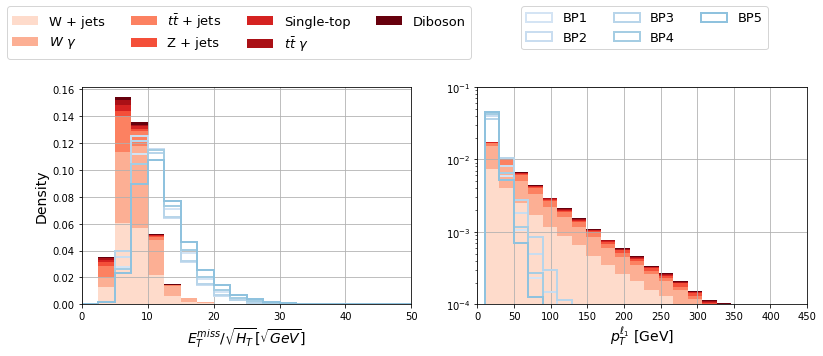

In [100]:
fig,ax = plt.subplots(1,2, figsize = (13,4))

# MET sig -----------------------------------------------------------------------------------------------------------------------
ncol = 0
nbins = 20 
bin_range = [0,50]

bkg_list = [MET_sig_wjets[:wjets_sample], MET_sig_wgamma[:wgamma_sample], MET_sig_ttjets[:ttjets_sample],
            MET_sig_zjets[:zjets_sample], 
            np.concatenate((MET_sig_tj[:tj_sample], MET_sig_tb[:tb_sample], MET_sig_tw[:tw_sample])), 
            MET_sig_ttgamma[:ttgamma_sample], 
            np.concatenate((MET_sig_zz[:zz_sample], MET_sig_wz[:wz_sample], MET_sig_ww[:ww_sample]))
           ]

ax[ncol].hist(bkg_list , nbins, stacked=True, density=True, color = colors, range = bin_range)
ax[ncol].legend(labels = bkg_labels,fontsize=13,bbox_to_anchor=(1.20, 1.4), ncol = 4) 

for i in BPs2plot:
    ax[ncol].hist(MET_sig_NP[i], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, range = bin_range, density = True)
    
ax[ncol].grid()
ax[ncol].set_xlabel(r"$E_{T}^{miss} / \sqrt{H_{T}} [\sqrt{GeV}]$",fontsize=14)
ax[ncol].set_ylabel("Density",fontsize=14)
#ax[ncol].set_yscale('log')
ax[ncol].set_xlim(0,50)
#ax[ncol].set_ylim(5e-5,1)

# Pt lepton -----------------------------------------------------------------------------------------------------------------------
ncol = 1
nbins  = 50
bin_range = [10,1000]

bkg_list = [lepton_wjets[:wjets_sample,0], lepton_wgamma[:wgamma_sample,0], lepton_ttjets[:ttjets_sample,0],
            lepton_zjets[:zjets_sample,0],
            np.concatenate((lepton_tj[:tj_sample,0], lepton_tb[:tb_sample,0], lepton_tw[:tw_sample,0])), 
            lepton_ttgamma[:ttgamma_sample,0], 
            np.concatenate((lepton_zz[:zz_sample,0], lepton_wz[:wz_sample,0], lepton_ww[:ww_sample,0]))]

ax[ncol].hist(bkg_list , nbins, stacked=True, density=True, color = colors, range = bin_range)


for i in BPs2plot:
    ax[ncol].hist(lepton_NP[i][:,0], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, range = bin_range, density = True, label = 'BP'+ str(i+1))
ax[ncol].legend(loc='upper right',fontsize=13,bbox_to_anchor=(0.9, 1.4), ncol = 3)


ax[ncol].grid()
ax[ncol].set_xlabel(r"$p_{T}^{\ell_{1}}$ [GeV]",fontsize=14)
ax[ncol].set_ylabel("")
ax[ncol].set_yscale('log')
ax[ncol].set_ylim(1e-4,0.1)
ax[ncol].set_xlim(0,450)

plt.savefig('../graph/MET_sig_PT_lepton_dist.pdf', bbox_inches='tight')

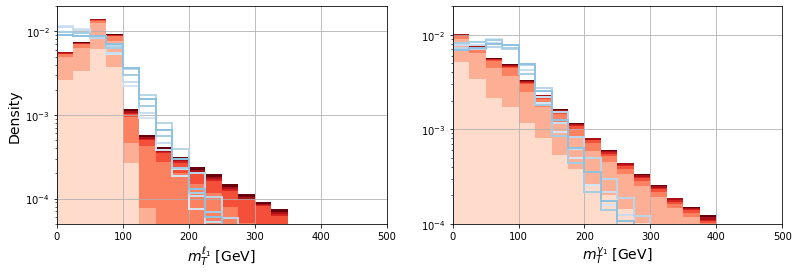

In [102]:
fig,ax = plt.subplots(1,2, figsize = (13,4))


# Mt lepton info -----------------------------------------------------------------------------------------------------------------------
ncol = 0
nbins = 20
bin_range = [0,500]

bkg_list = [mT_lepton_wjets[:wjets_sample], mT_lepton_wgamma[:wgamma_sample], mT_lepton_ttjets[:ttjets_sample],
            mT_lepton_zjets[:zjets_sample], 
            np.concatenate((mT_lepton_tj[:tj_sample], mT_lepton_tb[:tb_sample], mT_lepton_tw[:tw_sample])),
            mT_lepton_ttgamma[:ttgamma_sample],
            np.concatenate((mT_lepton_zz[:zz_sample], mT_lepton_wz[:wz_sample], mT_lepton_ww[:ww_sample]))
           ]

ax[ncol].hist(bkg_list , nbins, stacked=True, density=True, color = colors, range = bin_range)
#ax[ncol].legend(labels = bkg_labels,fontsize=13,bbox_to_anchor=(1.35, 1.4), ncol = 4) 

for i in BPs2plot:
    ax[ncol].hist(mT_lepton_NP[i], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, range = bin_range, density = True)

ax[ncol].grid()
ax[ncol].set_xlabel(r"$m_{T}^{\ell_{1}}$ [GeV]",fontsize=14)
ax[ncol].set_yscale('log')
ax[ncol].set_xlim(0,500)
ax[ncol].set_ylim(5e-5,2e-2)
ax[ncol].set_ylabel("Density",fontsize=14)

# Mt photon
ncol = 1
nbins = 20
bin_range = [0,500]

bkg_list = [mT_photon_wjets[:wjets_sample], mT_photon_wgamma[:wgamma_sample], mT_photon_ttjets[:ttjets_sample],
            mT_photon_zjets[:zjets_sample], 
            np.concatenate((mT_photon_tj[:tj_sample], mT_photon_tb[:tb_sample], mT_photon_tw[:tw_sample])),
            mT_photon_ttgamma[:ttgamma_sample],
            np.concatenate((mT_photon_zz[:zz_sample], mT_photon_wz[:wz_sample], mT_photon_ww[:ww_sample]))
           ]

ax[ncol].hist(bkg_list , nbins, stacked=True, density=True, color = colors, range = bin_range)

for i in BPs2plot:
    ax[ncol].hist(mT_photon_NP[i], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, range = bin_range, density = True, label = 'BP'+ str(i+1))
#ax[ncol].legend(loc='upper right',fontsize=13,bbox_to_anchor=(1., 1.4), ncol = 3)

ax[ncol].grid()
ax[ncol].set_xlabel(r"$m_{T}^{\gamma_{1}}$ [GeV]",fontsize=14)
ax[ncol].set_ylabel("")
ax[ncol].set_yscale('log')
ax[ncol].set_ylim(1e-4,2e-2)
ax[ncol].set_xlim(0,500)

plt.savefig('../graph/mt_lepton_mt_photon.pdf', bbox_inches='tight')

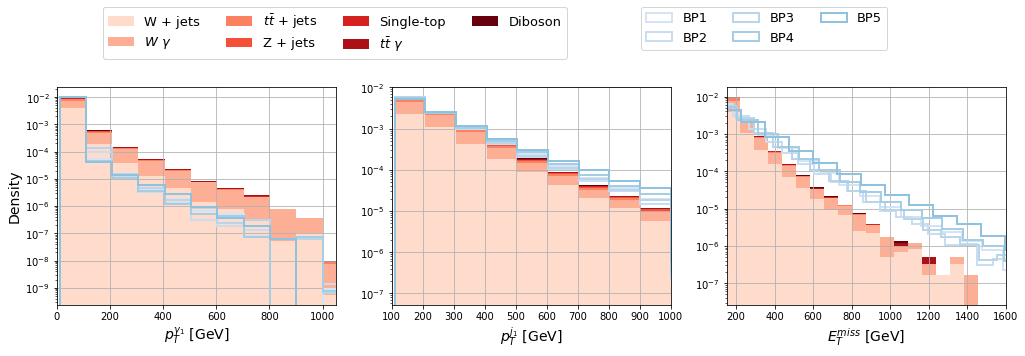

In [103]:
fig,ax = plt.subplots(1,3, figsize = (17,4))

# Pt Photon -----------------------------------------------------------------------------------------------------------------------
ncol  = 0
nbins = np.array([  10.,  109.,  208.,  307.,  406.,  505.,  604.,  703.,  802.,
         901., 1000.,10000])

bkg_list = [photon_wjets[:wjets_sample,0], photon_wgamma[:wgamma_sample,0], photon_ttjets[:ttjets_sample,0], 
            photon_zjets[:zjets_sample,0], 
            np.concatenate((photon_tj[:tj_sample,0], photon_tb[:tb_sample,0], photon_tw[:tw_sample,0])),
            photon_ttgamma[:ttgamma_sample,0], 
            np.concatenate((photon_zz[:zz_sample,0],photon_wz[:wz_sample,0],photon_ww[:ww_sample,0]))
           ]

ax[ncol].hist(bkg_list , bins = nbins, stacked=True, density=True, color = colors)
ax[ncol].legend(labels = bkg_labels,fontsize=13,bbox_to_anchor=(1.85, 1.4), ncol = 4) 


for i in BPs2plot:
    ax[ncol].hist(photon_NP[i][:,0], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True)

ax[ncol].grid()
ax[ncol].set_xlabel(r"$p_{T}^{\gamma_{1}}$ [GeV]",fontsize=14)
ax[ncol].set_yscale('log')
ax[ncol].set_xlim(0,1050)
ax[ncol].set_ylabel("Density",fontsize=14)


# Pt jet -----------------------------------------------------------------------------------------------------------------------
ncol = 1
nbins = np.array([109.,  208.,  307.,  406.,  505.,  604.,  703.,  802.,
         901., 1000.,10000])

bkg_list = [jet_wjets[:wjets_sample,0], jet_wgamma[:wgamma_sample,0], jet_ttjets[:ttjets_sample,0], 
            jet_zjets[:zjets_sample,0], 
            np.concatenate((jet_tj[:tj_sample,0], jet_tb[:tb_sample,0], jet_tw[:tw_sample,0])),
            jet_ttgamma[:ttgamma_sample,0],
            np.concatenate((jet_zz[:zz_sample,0],jet_wz[:wz_sample,0],jet_ww[:ww_sample,0]))
           ]
ax[ncol].hist(bkg_list , bins = nbins, stacked=True, density=True, color = colors)

for i in BPs2plot:
    ax[ncol].hist(jet_NP[i][:,0], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True, label = 'BP'+ str(i+1))
ax[ncol].legend(loc='upper right',fontsize=13,bbox_to_anchor=(1.8, 1.4), ncol = 3)
    
ax[ncol].grid()
ax[ncol].set_xlabel(r"$p_{T}^{j_{1}}$ [GeV]",fontsize=14)
ax[ncol].set_yscale('log')
ax[ncol].set_xlim(100,1000)



# Pt MET -----------------------------------------------------------------------------------------------------------------------
ncol = 2
nbins = 20
bin_range = [150,1600]

bkg_list = [MET_wjets[:wjets_sample,0], MET_wgamma[:wgamma_sample,0], MET_ttjets[:ttjets_sample,0], 
            MET_zjets[:zjets_sample,0], 
            np.concatenate((MET_tj[:tj_sample,0], MET_tb[:tb_sample,0], MET_tw[:tw_sample,0])),
            MET_ttgamma[:ttgamma_sample,0],
            np.concatenate((MET_zz[:zz_sample,0],MET_wz[:wz_sample,0],MET_ww[:ww_sample,0]))
           ]
ax[ncol].hist(bkg_list , bins = nbins, stacked=True, density=True, color = colors, range = bin_range)

for i in BPs2plot:
    ax[ncol].hist(MET_NP[i][:,0], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True)


ax[ncol].grid()
ax[ncol].set_xlabel(r"$E_{T}^{miss}$ [GeV]",fontsize=14)
ax[ncol].set_yscale('log')
ax[ncol].set_xlim(150,1600)

plt.savefig('../graph/PT_photon_PT_jet_ETmiss.pdf', bbox_inches='tight')

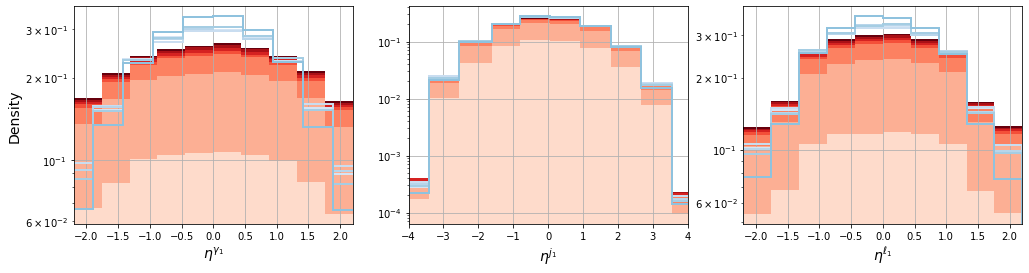

In [104]:
fig,ax = plt.subplots(1,3, figsize = (17,4))

# eta Photon -----------------------------------------------------------------------------------------------------------------------
ncol = 0
nbins = 10
bin_range = [-2.2,2.2]

bkg_list = [photon_wjets[:wjets_sample,1], photon_wgamma[:wgamma_sample,1], photon_ttjets[:ttjets_sample,1],
            photon_zjets[:zjets_sample,1], 
            np.concatenate((photon_tj[:tj_sample,1], photon_tb[:tb_sample,1], photon_tw[:tw_sample,1])),
            photon_ttgamma[:ttgamma_sample,1],
            np.concatenate((photon_zz[:zz_sample,1],photon_wz[:wz_sample,1],photon_ww[:ww_sample,1]))
           ]

ax[ncol].hist(bkg_list , bins = nbins, stacked=True, density=True, color = colors, range = bin_range)

for i in BPs2plot:
    ax[ncol].hist(photon_NP[i][:,1], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True)

ax[ncol].grid()
ax[ncol].set_xlabel(r"$\eta^{\gamma_{1}}$",fontsize=14)
ax[ncol].set_yscale('log')
ax[ncol].set_xlim(-2.2,2.2)
ax[ncol].set_ylabel("Density",fontsize=14)


# eta jet -----------------------------------------------------------------------------------------------------------------------
ncol = 1
nbins = np.asarray([-8.3 , -3.42, -2.55, -1.62, -0.80, 0.063 , 0.93, 1.80, 2.68, 3.55, 8.42])

bkg_list = [jet_wjets[:wjets_sample,1], jet_wgamma[:wgamma_sample,1], jet_ttjets[:ttjets_sample,1],
            jet_zjets[:zjets_sample,1], 
            np.concatenate((jet_tj[:tj_sample,1], jet_tb[:tb_sample,1], jet_tw[:tw_sample,1])),
            jet_ttgamma[:ttgamma_sample,1], 
            np.concatenate((jet_zz[:zz_sample,1],jet_wz[:wz_sample,1],jet_ww[:ww_sample,1]))
           ]

ax[ncol].hist(bkg_list , bins = nbins, stacked=True, density=True, color = colors, range = bin_range)

for i in BPs2plot:
    ax[ncol].hist(jet_NP[i][:,1], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True)

ax[ncol].grid()
ax[ncol].set_xlabel(r"$\eta^{j_{1}}$",fontsize=14)
ax[ncol].set_ylabel("")
ax[ncol].set_yscale('log')
ax[ncol].set_xlim(-4.,4.)


# eta lepton -----------------------------------------------------------------------------------------------------------------------
ncol = 2
nbins = 10
bin_range = [-2.2,2.2]

bkg_list = [lepton_wjets[:wjets_sample,1], lepton_wgamma[:wgamma_sample,1], lepton_ttjets[:ttjets_sample,1],
            lepton_zjets[:zjets_sample,1], 
            np.concatenate((lepton_tj[:tj_sample,1], lepton_tb[:tb_sample,1], lepton_tw[:tw_sample,1])),
            lepton_ttgamma[:ttgamma_sample,1],
            np.concatenate((lepton_zz[:zz_sample,1],lepton_wz[:wz_sample,1],lepton_ww[:ww_sample,1]))
           ]

ax[ncol].hist(bkg_list , bins = nbins, stacked=True, density=True, color = colors, range = bin_range)

for i in BPs2plot:
    ax[ncol].hist(lepton_NP[i][:,1], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True, range = bin_range)

ax[ncol].grid()
ax[ncol].set_xlabel(r"$\eta^{\ell_{1}}$",fontsize=14)
ax[ncol].set_yscale('log')
ax[ncol].set_xlim(-2.2,2.2)

plt.savefig('../graph/eta_photon_lepton_jet_dist.pdf', bbox_inches='tight')

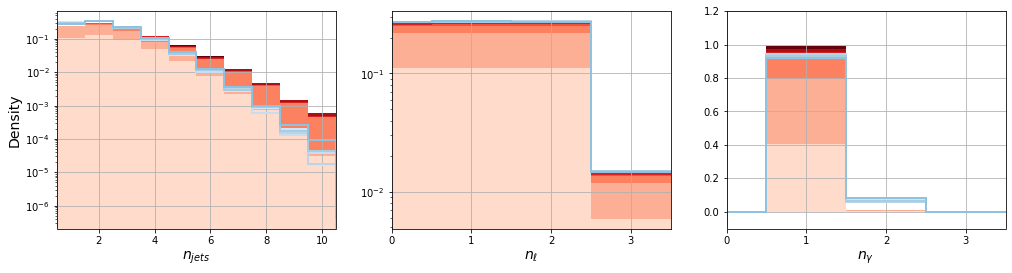

In [105]:
fig,ax = plt.subplots(1,3, figsize = (17,4))


# Num jets
ncol = 0
nbins = np.asarray([-0.5,0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,25])

bkg_list = [hadinfo_wjets[:wjets_sample,2], hadinfo_wgamma[:wgamma_sample,2], hadinfo_ttjets[:ttjets_sample,2],
            hadinfo_zjets[:zjets_sample,2], 
            np.concatenate((hadinfo_tj[:tj_sample,2], hadinfo_tb[:tb_sample,2], hadinfo_tw[:tw_sample,2])),
            hadinfo_ttgamma[:ttgamma_sample,2],
            np.concatenate((hadinfo_zz[:zz_sample,2],hadinfo_wz[:wz_sample,2],hadinfo_ww[:ww_sample,2]))
           ]

ax[ncol].hist(bkg_list , bins = nbins, stacked=True, density=True, color = colors)

for i in BPs2plot:
    ax[ncol].hist(hadinfo_NP[i][:,2], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True)

ax[ncol].grid()
ax[ncol].set_xlabel(r"$n_{jets}$ ",fontsize=14)
ax[ncol].set_yscale('log')
ax[ncol].set_xlim(0.5,10.5)

ax[ncol].set_ylabel("Density",fontsize=14)

# Num leptons
ncol = 1
nbins = np.asarray([-0.5,0.5,1.5,2.5,14.5])

bkg_list = [lepton_wjets[:wjets_sample,2], lepton_wgamma[:wgamma_sample,2], lepton_ttjets[:ttjets_sample,2],
            lepton_zjets[:zjets_sample,2], 
            np.concatenate((lepton_tj[:tj_sample,2], lepton_tb[:tb_sample,2], lepton_tw[:tw_sample,2])),
            lepton_ttgamma[:ttgamma_sample,2],
            np.concatenate((lepton_zz[:zz_sample,2],lepton_wz[:wz_sample,2],lepton_ww[:ww_sample,2]))
           ]

ax[ncol].hist(bkg_list , bins = nbins, stacked=True, density=True, color = colors)

for i in BPs2plot:
    ax[ncol].hist(lepton_NP[i][:,2], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True)

ax[ncol].grid()
ax[ncol].set_xlabel(r"$n_{\ell}$ ",fontsize=14)
ax[ncol].set_ylabel("")
ax[ncol].set_yscale('log')
ax[ncol].set_xlim(0.5,3.5)
ax[ncol].set_xticks([0,1,2,3])


# Num photons
ncol = 2
bins = [0.5,1.5,2.5,3.5,4.5]

bkg_list = [photon_wjets[:wjets_sample,3], photon_wgamma[:wgamma_sample,3], photon_ttjets[:ttjets_sample,3],
            photon_zjets[:zjets_sample,3], 
            np.concatenate((photon_tj[:tj_sample,3], photon_tb[:tb_sample,3], photon_tw[:tw_sample,3])),
            photon_ttgamma[:ttgamma_sample,3],
            np.concatenate((photon_zz[:zz_sample,3],photon_wz[:wz_sample,3],photon_ww[:ww_sample,3]))
           ]

ax[ncol].hist(bkg_list , bins = nbins, stacked=True, density=True, color = colors)

for i in BPs2plot:
    ax[ncol].hist(photon_NP[i][:,3], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True)

ax[ncol].grid()
ax[ncol].set_xlabel(r"$n_{\gamma}$",fontsize=14)
ax[ncol].set_ylabel("")
ax[ncol].set_xlim(0.5,3.5)
ax[ncol].set_ylim(-0.1,1.2)
ax[ncol].set_xticks([0,1,2,3])

plt.savefig('../graph/njets_nleptons_nphoton.pdf', bbox_inches='tight')

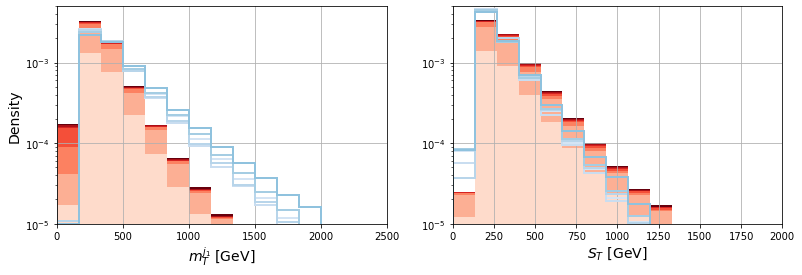

In [106]:
fig,ax = plt.subplots(1,2, figsize = (13,4))

# Mt jet info -----------------------------------------------------------------------------------------------------------------------
ncol = 0
nbins = 15
bin_range = [0,2500]

bkg_list = [mT_jet_wjets[:wjets_sample], mT_jet_wgamma[:wgamma_sample], mT_jet_ttjets[:ttjets_sample],
            mT_jet_zjets[:zjets_sample], 
            np.concatenate((mT_jet_tj[:tj_sample], mT_jet_tb[:tb_sample], mT_jet_tw[:tw_sample])),
            mT_jet_ttgamma[:ttgamma_sample],
            np.concatenate((mT_jet_zz[:zz_sample], mT_jet_wz[:wz_sample], mT_jet_ww[:ww_sample]))
           ]

ax[ncol].hist(bkg_list , bins = nbins, stacked=True, density=True, color = colors, range = bin_range)

for i in BPs2plot:
    ax[ncol].hist(mT_jet_NP[i], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True, range = bin_range)

ax[ncol].grid()
ax[ncol].set_xlabel(r"$m_{T}^{j_{1}}$ [GeV]",fontsize=14)
ax[ncol].set_ylabel("")
ax[ncol].set_yscale('log')
ax[ncol].set_xlim(0,2500)
ax[ncol].set_ylim(1e-5,5e-3)
ax[ncol].set_ylabel("Density",fontsize=14)


# ST info
ncol = 1
nbins = 15
bin_range = [0,2000]

bkg_list = [ST_wjets[:wjets_sample], ST_wgamma[:wgamma_sample], ST_ttjets[:ttjets_sample],
            ST_zjets[:zjets_sample], 
            np.concatenate((ST_tj[:tj_sample], ST_tb[:tb_sample], ST_tw[:tw_sample])),
            ST_ttgamma[:ttgamma_sample],
            np.concatenate((ST_zz[:zz_sample], ST_wz[:wz_sample], ST_ww[:ww_sample]))
           ]

ax[ncol].hist(bkg_list , bins = nbins, stacked=True, density=True, color = colors, range = bin_range)

for i in BPs2plot:
    ax[ncol].hist(ST_NP[i], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True, range = bin_range)

ax[ncol].grid()
ax[ncol].set_xlabel(r"$S_{T}$ [GeV]",fontsize=14)
ax[ncol].set_yscale('log')
ax[ncol].set_xlim(0,2000)
ax[ncol].set_ylim(1e-5,5e-3)

plt.savefig('../graph/mt_jet_ST.pdf', bbox_inches='tight')

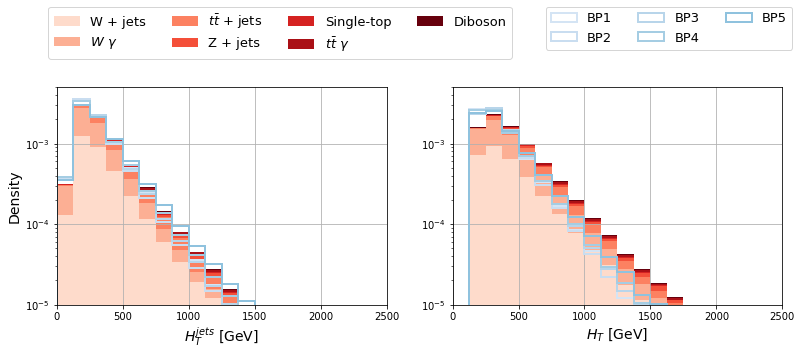

In [107]:
nbins = 20#np.asarray([121.16, 467.7, 814.2, 1160.8, 1507.3, 1853.9, 2200.4, 2546.9, 2893.5, 3240.0, 10000])

fig,ax = plt.subplots(1,2, figsize = (13,4))

# Ht info -----------------------------------------------------------------------------------------------------------------------
ncol = 0
xlabels = [r"$H_{T}^{jets}$ [GeV]", r"$H_{T}^{jets}$ [GeV]"]
bin_range = [0,2500]
nbins = 20

bkg_list = [hadinfo_wjets[:wjets_sample,1], hadinfo_wgamma[:wgamma_sample,1], hadinfo_ttjets[:ttjets_sample,1],
            hadinfo_zjets[:zjets_sample,1], 
            np.concatenate((hadinfo_tj[:tj_sample,1], hadinfo_tb[:tb_sample,1], hadinfo_tw[:tw_sample,1])),
            hadinfo_ttgamma[:ttgamma_sample,1],
            np.concatenate((hadinfo_zz[:zz_sample,1],hadinfo_wz[:wz_sample,1],hadinfo_ww[:ww_sample,1]))
           ]

ax[ncol].hist(bkg_list , bins = nbins, stacked=True, density=True, color = colors, range = bin_range)
ax[ncol].legend(labels = bkg_labels,fontsize=13,bbox_to_anchor=(1.40, 1.4), ncol = 4) 

for i in BPs2plot:
    ax[ncol].hist(hadinfo_NP[i][:,1], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True, range = bin_range)

ax[ncol].grid()
ax[ncol].set_xlabel(r"$H_{T}^{jets}$ [GeV]",fontsize=14)
ax[ncol].set_ylabel("Density",fontsize=14)
ax[ncol].set_yscale('log')
ax[ncol].set_xlim(0,2500)
ax[ncol].set_ylim(1e-5,5e-3)

# HT
ncol = 1

bkg_list = [hadinfo_wjets[:wjets_sample,0], hadinfo_wgamma[:wgamma_sample,0], hadinfo_ttjets[:ttjets_sample,0],
            hadinfo_zjets[:zjets_sample,0], 
            np.concatenate((hadinfo_tj[:tj_sample,0], hadinfo_tb[:tb_sample,0], hadinfo_tw[:tw_sample,0])),
            hadinfo_ttgamma[:ttgamma_sample,0],
            np.concatenate((hadinfo_zz[:zz_sample,0],hadinfo_wz[:wz_sample,0],hadinfo_ww[:ww_sample,0]))
           ]

ax[ncol].hist(bkg_list , bins = nbins, stacked=True, density=True, color = colors, range = bin_range)

for i in BPs2plot:
    ax[ncol].hist(hadinfo_NP[i][:,0], bins=nbins, lw=2, edgecolor=cmap(i+3), histtype='step', zorder=2, density = True, range = bin_range, label = 'BP'+ str(i+1))
ax[ncol].legend(loc='upper right',fontsize=13,bbox_to_anchor=(1.05, 1.4), ncol = 3)
    
ax[ncol].grid()
ax[ncol].set_xlabel(r"$H_{T}$ [GeV]",fontsize=14)
ax[ncol].set_ylabel("")
ax[ncol].set_yscale('log')
ax[ncol].set_xlim(0,2500)
ax[ncol].set_ylim(1e-5,5e-3)

plt.savefig('../graph/HT_info_dist.pdf', bbox_inches='tight')